In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
import sklearn.metrics as mtcs
import sklearn.preprocessing as pp
import sklearn.linear_model as lm
import sklearn.ensemble as ens
import sklearn.feature_selection as fs
import sklearn.neural_network as nn

from sklearn.pipeline import Pipeline
from sklearn.linear_model.base import BaseEstimator
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from tqdm import tqdm
from statsmodels.stats.weightstats import ztest
from xgboost import XGBClassifier
from tempfile import mkdtemp

%matplotlib inline
output_notebook()

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Loading BokehJS ...

# Common functions

In [100]:
ALL = 1524

def weight_init(name, shape):
    return tf.get_variable(name, initializer=tf.random_normal(shape=shape,
                                                              stddev=0.1))
def bias_init(name, shape):
    return tf.get_variable(name, initializer=tf.constant(0.1, shape=shape))

def elastic_net(x, l1, l2):
    return l1 * ( (1-l2) / 2 * tf.norm(x, 2) ** 2 + 
                   l2 * tf.norm(x, 1))

def batch_data(*matrxs, batch_size):
    for batch_i in range(matrxs[0].shape[0] // batch_size):
        yield tuple(x.iloc[batch_i * batch_size : (batch_i + 1) * batch_size] 
                     for x in matrxs)
        
def split_data3(data, train_size=0.5, test_size=0.25, validate_size=0.25):
    train_data, test_val_data = ms.train_test_split(data, train_size=train_size)
    test_data, val_data = ms.train_test_split(test_val_data,
                                              train_size=test_size / (test_size+validate_size))
    
    train_X, train_y = train_data.drop('y', axis=1), train_data[['y']]
    test_X, test_y = test_data.drop('y', axis=1), test_data[['y']]
    validate_X, validate_y = val_data.drop('y', axis=1), val_data[['y']]
    
    return (train_X, train_y, test_X, test_y, validate_X, validate_y)

def split_data2(data, train_size, test_size):
    train_data, test_data = ms.train_test_split(data, train_size=train_size,
                                                stratify=data.y, shuffle=True)
    train_X, train_y = train_data.drop('y', axis=1), train_data[['y']]
    test_X, test_y = test_data.drop('y', axis=1), test_data[['y']]
    
    return (train_X, train_y, test_X, test_y)
    
def drop_correllated_ftrs(data, corr):
    y = data.y
    data = data.drop('y', axis=1)
    
    corr_matrix = data.corr(corr).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
    const = list(filter(lambda col: len(data[col].unique()) == 1, data.columns ))
    to_drop += const
    data = data.drop(to_drop, axis=1)
    
    data['y'] = y
    print(f"Dropped {len(to_drop)} correlated features")
    
    return data

def pp_pipeline(data):
    scaler = pp.StandardScaler()
    
    data_pp = scaler.fit_transform(data)
    
    data_pp = pd.DataFrame(data_pp,
                        index=data.index,
                        columns=data.columns)
    
    #restore target
    data_pp.y = data.y
    
    data_pp = drop_correllated_ftrs(data_pp, 'pearson')
    data_pp = drop_correllated_ftrs(data_pp, 'spearman')
    
    return data_pp

def main_metric(y_true, y_pred):
    return mtcs.accuracy_score(y_true, y_pred)

# Data uploading&preview

In [101]:
data = _data_ = pd.read_csv('./data/train.csv')

data

,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,...,feature-1515,feature-1516,feature-1517,feature-1518,feature-1519,feature-1520,feature-1521,feature-1522,feature-1523,y
0,37.977273,6.758452,3.636364,10.792929,160.801682,151.109783,1.791689,6.818675,8.138413,8.270161,...,5.658393,4.151040,4.540632,4.953183,5.351562,5.311048,5.560922,5.643015,5.715999,0.0
1,19.408163,5.933978,2.816327,5.877551,162.949911,76.153796,1.381401,6.002651,5.080499,7.514421,...,4.830811,3.817712,4.123094,4.426343,4.823804,4.652173,4.795274,4.860781,5.001426,0.0
2,40.265306,7.425645,3.734694,13.160998,172.099640,161.790879,1.603976,7.410120,10.114794,8.805738,...,6.397659,4.223177,4.685597,5.116870,5.333926,5.504569,5.797956,6.009581,6.200889,0.0
3,43.976744,7.648293,3.837209,14.392765,168.885456,175.277251,1.622298,7.629033,12.180817,9.070719,...,5.879135,4.280132,4.563045,5.007714,5.159773,5.393628,5.640132,5.472271,5.741399,0.0
4,24.320988,6.534011,3.567901,8.913580,163.076959,96.019681,1.380679,6.566695,4.417010,8.058783,...,8.148663,4.624973,5.173321,5.720312,6.259342,6.626469,7.062406,7.472998,7.829842,0.0
5,20.924051,6.134299,3.037975,6.506329,165.707039,82.761541,1.381957,6.187547,4.684599,7.660347,...,6.087556,4.430817,4.820282,5.183187,5.595176,5.489454,5.604998,5.847522,5.987080,0.0
6,34.150000,6.740695,3.733333,10.214815,164.252922,135.639059,1.620887,6.781702,8.631090,8.248393,...,6.198225,4.471639,4.801970,5.237107,5.493833,5.573816,5.764799,5.865760,5.998937,0.0
7,23.833333,6.395508,3.141026,8.717949,163.221967,94.106131,1.435936,6.443753,5.834402,7.904135,...,6.582328,4.600158,5.032071,5.499726,5.978728,5.995208,6.179952,6.364051,6.481290,0.0
8,32.380952,6.152543,2.857143,6.402116,164.380868,128.391104,1.687697,6.232890,4.476844,7.736528,...,0.000000,3.449988,3.865979,4.506730,4.765906,4.965028,3.840795,3.595598,0.000000,0.0
9,45.228571,6.608449,3.714286,9.180952,159.167580,180.141749,1.981354,6.690537,8.428546,8.221041,...,5.214936,3.828641,4.234107,4.682131,4.890349,5.192957,5.342334,5.402677,5.303305,0.0


[ 0.  1.]


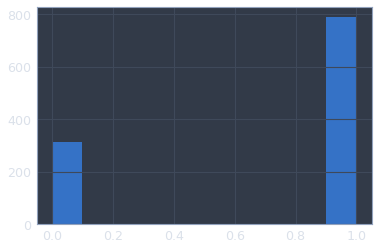

In [102]:
print(data.y.unique())
plt.hist(data.y);

In [103]:
print(data.isnull().sum().sum())

num_1 = data[data.y == 1].shape[0] 
num_0 = data[data.y == 0].shape[0]

print(num_1, num_0, num_1 / (num_0 + num_1))

0
790 315 0.7149321266968326


In [104]:
data = pp_pipeline(_data_)

data_X = data.drop('y', axis=1)
data_y = data[['y']]

Dropped 1279 correlated features
Dropped 20 correlated features


In [105]:
(train_X, train_y, test_X, test_y) = split_data2(data, train_size=0.8, test_size=0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Feature selection

## DFS

In [183]:
class DFS(BaseEstimator):
    def __init__(self, layers_sizes=[128, 64, 2], batch_size=32, lambda1=1e-3, lambda2=1.,
                 alpha1=1e-3, alpha2=0., num_epochs=10, verbose=0, N=None, 
                 dropout_rate=1.):
        self.layers_sizes = layers_sizes
        self.num_layers = len(layers_sizes)
        self.batch_size = batch_size
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_epochs = num_epochs
        self.verbose = verbose
        self.N = N
        self.dropout_rate = dropout_rate
        
        
    def fit(self, X, y, test_data=None):
        self._build_graph_(X.shape[1])
        self.features = X.columns #Persisting for `select_most_important_ftrs`
        self.sess = tf.Session()
        
        self.sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(self.num_epochs):
            X_cur = X.sample(frac=1, random_state=epoch_i)
            y_cur = y.sample(frac=1, random_state=epoch_i)
            epoch_loss = 0
            for batch_X, batch_y in batch_data(X_cur, y_cur, 
                                               batch_size=self.batch_size):
                train_loss, _ = self.sess.run([self.total_loss, self.train_step],
                                               feed_dict = {self.x: batch_X,
                                                            self.y: batch_y,
                                                            self.dropout_rate_ph: self.dropout_rate})
                epoch_loss += train_loss
            epoch_loss /= X.shape[0] // self.batch_size
            
            train_predict = self.predict(X_cur)
            train_accuracy = mtcs.accuracy_score(y_cur, train_predict)
            
            if self.verbose:
                if test_data is not None:
                    test_X, test_y = test_data
                    test_predict = self.predict(test_X)
                    test_accuracy = mtcs.accuracy_score(test_y, test_predict)
                    print(f"==> Epoch: {epoch_i}. Train loss: {epoch_loss}."
                          f"Train accuracy: {train_accuracy}. Test accuracy: {test_accuracy}.")
                else:
                    print(f"==> Epoch: {epoch_i}. Train loss: {epoch_loss}. "
                          f"Train accuracy: {train_accuracy}.")
                
        return self
       
    
    def predict_proba(self, X):
        predictions_proba = self.sess.run(self.predictions, 
                                          feed_dict={self.x: X,
                                                     self.dropout_rate_ph: 1.})
        
        return predictions_proba
    
    
    def predict(self, X):
        predictions_proba = self.predict_proba(X)
        
        return list(map(np.argmax, predictions_proba))
    
    
    def get_features_weights(self):
        weights = self.sess.run(self.features_weights)
        
        return weights
    
    
    def select_most_important_ftrs(self, N):
        weights = self.get_features_weights()
        feature_weight = sorted(zip(weights, self.features), 
                                key=lambda x: abs(x[0]))
        
        return map(lambda x: x[1], feature_weight[-N:])
    
    
    def select_most_important_ftrs_thresh(self, thresh=0.1):
        weights = self.get_features_weights()
        feature_weight = filter(lambda x: x[0] >= thresh,
                                zip(weights, self.features))
        
        return map(lambda x: x[1], feature_weight)
    
    
    def transform(self, X, N=None, threshold=None):
        if N:
            features = list(self.select_most_important_ftrs(N))
        elif self.N:
            features = list(self.select_most_important_ftrs(self.N))
        else:
            features = list(self.select_most_important_ftrs_thresh(threshold))
        
        return X[features]
    
     
    def _build_graph_(self, num_features):
        tf.reset_default_graph()
        
        ###Placeholders 
        x = tf.placeholder(tf.float32, [None, num_features], 'x_ph')
        y = tf.placeholder(tf.int32, [None], 'y_ph')
        dropout_rate_ph = tf.placeholder(tf.float32, None, 'dropout_rate')
        
        ###Weights initialization
        w = tf.get_variable("dfs_features_weight", 
                            initializer = tf.constant(1., shape=[num_features]))
        self.layers_sizes = [num_features] + self.layers_sizes
        W, b = [], []
        for layer_i in range(self.num_layers):
            W.append(weight_init(f"layer_{layer_i}_weights",
                                 shape=[self.layers_sizes[layer_i],
                                        self.layers_sizes[layer_i+1]]))
            b.append(bias_init(f"layer_{layer_i}_bias",
                               shape=[self.layers_sizes[layer_i+1]]))
        
        ###Input transformations
        logits = x * w #feature selection
        for layer_i in range(self.num_layers):
            if layer_i != self.num_layers - 1:
                logits = tf.nn.dropout(
                            tf.nn.relu(tf.matmul(logits, W[layer_i]) + b[layer_i]),
                            keep_prob=dropout_rate_ph)
            else:
                logits = tf.matmul(logits, W[layer_i]) + b[layer_i]
        predictions = tf.nn.softmax(logits)
            
        ###Loss calculation
        logloss = tf.reduce_sum(
                        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, 
                                                                       logits=logits))
        w_loss = elastic_net(w, self.lambda1, self.lambda2)
        W_loss = tf.reduce_sum([elastic_net(W_i, self.alpha1, self.alpha2) for W_i in W])
        
        total_loss = tf.reduce_sum(logloss + w_loss + W_loss)
        
        ###Optimizer
        train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)
        
        self.x = x
        self.y = y
        self.dropout_rate_ph = dropout_rate_ph
        self.predictions = predictions
        self.total_loss = total_loss
        self.train_step = train_step
        self.features_weights = w
        

In [192]:
param_grid = [
    {
        'layers_sizes': [[64, 64, 32, 2]],
        'lambda1': np.arange(1e-2, 1, 2e-1),
        'alpha1': np.arange(1e-2, 1, 2e-1),
        'num_epochs': [200],
        'dropout_rate': [0.25],
    }
]

grid = ms.GridSearchCV(DFS(), param_grid, scoring='accuracy', verbose=100)

grid.fit(train_X, train_y.y)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] alpha1=0.01, dropout_rate=0.25, lambda1=0.01, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  alpha1=0.01, dropout_rate=0.25, lambda1=0.01, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.8508474576271187, total=  19.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.2s remaining:    0.0s
[CV] alpha1=0.01, dropout_rate=0.25, lambda1=0.01, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  alpha1=0.01, dropout_rate=0.25, lambda1=0.01, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.8542372881355932, total=  19.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.2s remaining:    0.0s
[CV] alpha1=0.01, dropout_rate=0.25, lambda1=0.01, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  alpha1=0.01, dropout_rate=0.25, lambda1=0.01, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.8673469387755102, total=  19.6s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   57.8s remaining:   

[CV]  alpha1=0.21, dropout_rate=0.25, lambda1=0.61, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.7006802721088435, total=  19.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  8.6min remaining:    0.0s
[CV] alpha1=0.21, dropout_rate=0.25, lambda1=0.81, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  alpha1=0.21, dropout_rate=0.25, lambda1=0.81, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.7254237288135593, total=  18.8s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  9.0min remaining:    0.0s
[CV] alpha1=0.21, dropout_rate=0.25, lambda1=0.81, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  alpha1=0.21, dropout_rate=0.25, lambda1=0.81, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.7186440677966102, total=  19.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:  9.3min remaining:    0.0s
[CV] alpha1=0.21, dropout_rate=0.25, lambda1=0.81, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  alpha1=0.21, dropout_rate=0.25, lambda1=0.81, lay

[CV]  alpha1=0.61, dropout_rate=0.25, lambda1=0.41, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.7006802721088435, total=  19.2s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 17.4min remaining:    0.0s
[CV] alpha1=0.61, dropout_rate=0.25, lambda1=0.61, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  alpha1=0.61, dropout_rate=0.25, lambda1=0.61, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.7254237288135593, total=  19.4s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed: 17.7min remaining:    0.0s
[CV] alpha1=0.61, dropout_rate=0.25, lambda1=0.61, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  alpha1=0.61, dropout_rate=0.25, lambda1=0.61, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.7186440677966102, total=  19.2s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed: 18.0min remaining:    0.0s
[CV] alpha1=0.61, dropout_rate=0.25, lambda1=0.61, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  alpha1=0.61, dropout_rate=0.25, lambda1=0.61, lay

GridSearchCV(cv=None, error_score='raise',
       estimator=DFS(N=None, alpha1=0.001, alpha2=0.0, batch_size=32, dropout_rate=1.0,
  lambda1=0.001, lambda2=1.0, layers_sizes=[128, 64, 2], num_epochs=10,
  verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'layers_sizes': [[64, 64, 32, 2]], 'lambda1': array([ 0.01,  0.21,  0.41,  0.61,  0.81]), 'alpha1': array([ 0.01,  0.21,  0.41,  0.61,  0.81]), 'num_epochs': [200], 'dropout_rate': [0.25]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=100)

In [198]:
param_grid = [
    {
        'layers_sizes': [[64, 64, 32, 2]],
        'lambda1': np.arange(1e-3, 1e-1, 2e-2),
#         'alpha1': np.arange(1e-2, 1, 2e-1),
        'num_epochs': [200],
        'dropout_rate': [0.25],
    }
]

grid = ms.GridSearchCV(DFS(), param_grid, scoring='accuracy', verbose=100)

grid.fit(train_X, train_y.y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] dropout_rate=0.25, lambda1=0.001, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  dropout_rate=0.25, lambda1=0.001, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.847457627118644, total=  19.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.3s remaining:    0.0s
[CV] dropout_rate=0.25, lambda1=0.001, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  dropout_rate=0.25, lambda1=0.001, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.8677966101694915, total=  19.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.6s remaining:    0.0s
[CV] dropout_rate=0.25, lambda1=0.001, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  dropout_rate=0.25, lambda1=0.001, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.8639455782312925, total=  18.8s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   57.4s remaining:    0.0s
[CV] dropout_rate=0.25, lambda1=0.021, layers_sizes=[64, 64, 32, 2],

GridSearchCV(cv=None, error_score='raise',
       estimator=DFS(N=None, alpha1=0.001, alpha2=0.0, batch_size=32, dropout_rate=1.0,
  lambda1=0.001, lambda2=1.0, layers_sizes=[128, 64, 2], num_epochs=10,
  verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'layers_sizes': [[64, 64, 32, 2]], 'lambda1': array([ 0.001,  0.021,  0.041,  0.061,  0.081]), 'num_epochs': [200], 'dropout_rate': [0.25]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=100)

In [204]:
param_grid = [
    {
        'layers_sizes': [[64, 64, 32, 2]],
        'lambda1': np.arange(1e-3, 1e-1, 2e-2),
        'alpha1': np.arange(1e-2, 1, 5e-1),
        'num_epochs': [200],
        'dropout_rate': [0.25],
    }
]

grid2 = ms.GridSearchCV(DFS(), param_grid, scoring='accuracy', verbose=100)

grid2.fit(train_X, train_y.y)

SyntaxError: invalid syntax (<ipython-input-204-c99cb7d35c3f>, line 6)

In [205]:
param_grid = [
    {
        'layers_sizes': [[64, 64, 32, 2]],
        'lambda1': np.arange(0.030, 0.080, 0.005),
        'alpha1': [0.01],
        'num_epochs': [200],
        'dropout_rate': [0.25],
    }
]

grid3 = ms.GridSearchCV(DFS(), param_grid, scoring='accuracy', verbose=100)

grid3.fit(train_X, train_y.y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] alpha1=0.01, dropout_rate=0.25, lambda1=0.03, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  alpha1=0.01, dropout_rate=0.25, lambda1=0.03, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.8576271186440678, total=  19.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.2s remaining:    0.0s
[CV] alpha1=0.01, dropout_rate=0.25, lambda1=0.03, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  alpha1=0.01, dropout_rate=0.25, lambda1=0.03, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.8610169491525423, total=  18.9s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.1s remaining:    0.0s
[CV] alpha1=0.01, dropout_rate=0.25, lambda1=0.03, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  alpha1=0.01, dropout_rate=0.25, lambda1=0.03, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.8707482993197279, total=  19.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   57.4s remaining:   

[CV]  alpha1=0.01, dropout_rate=0.25, lambda1=0.07, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.8877551020408163, total=  19.3s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  8.7min remaining:    0.0s
[CV] alpha1=0.01, dropout_rate=0.25, lambda1=0.075, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  alpha1=0.01, dropout_rate=0.25, lambda1=0.075, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.8576271186440678, total=  18.9s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  9.1min remaining:    0.0s
[CV] alpha1=0.01, dropout_rate=0.25, lambda1=0.075, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  alpha1=0.01, dropout_rate=0.25, lambda1=0.075, layers_sizes=[64, 64, 32, 2], num_epochs=200, score=0.8711864406779661, total=  19.3s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:  9.4min remaining:    0.0s
[CV] alpha1=0.01, dropout_rate=0.25, lambda1=0.075, layers_sizes=[64, 64, 32, 2], num_epochs=200 
[CV]  alpha1=0.01, dropout_rate=0.25, lambda1=0.07

GridSearchCV(cv=None, error_score='raise',
       estimator=DFS(N=None, alpha1=0.001, alpha2=0.0, batch_size=32, dropout_rate=1.0,
  lambda1=0.001, lambda2=1.0, layers_sizes=[128, 64, 2], num_epochs=10,
  verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'layers_sizes': [[64, 64, 32, 2]], 'lambda1': array([ 0.03 ,  0.035,  0.04 ,  0.045,  0.05 ,  0.055,  0.06 ,  0.065,
        0.07 ,  0.075]), 'alpha1': [0.01], 'num_epochs': [200], 'dropout_rate': [0.25]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=100)

In [184]:
dfs = DFS([64, 64, 32, 2], lambda1=2, alpha1=1e-2,  num_epochs=1000, verbose=True, dropout_rate=0.5)

dfs.fit(train_X, train_y['y'], test_data=(test_X, test_y))

==> Epoch: 0. Train loss: 465.47497784649886.Train accuracy: 0.7149321266968326. Test accuracy: 0.7149321266968326.
==> Epoch: 1. Train loss: 452.4825032552083.Train accuracy: 0.7149321266968326. Test accuracy: 0.7149321266968326.
==> Epoch: 2. Train loss: 439.6175548412182.Train accuracy: 0.7149321266968326. Test accuracy: 0.7149321266968326.
==> Epoch: 3. Train loss: 427.1764142071759.Train accuracy: 0.7149321266968326. Test accuracy: 0.7149321266968326.
==> Epoch: 4. Train loss: 414.29669980649595.Train accuracy: 0.7149321266968326. Test accuracy: 0.7149321266968326.
==> Epoch: 5. Train loss: 401.23277000144674.Train accuracy: 0.7771493212669683. Test accuracy: 0.8009049773755657.
==> Epoch: 6. Train loss: 388.2038415979456.Train accuracy: 0.8099547511312217. Test accuracy: 0.8371040723981901.
==> Epoch: 7. Train loss: 374.73662425853587.Train accuracy: 0.8359728506787331. Test accuracy: 0.8552036199095022.
==> Epoch: 8. Train loss: 362.15824494538487.Train accuracy: 0.8416289592760

==> Epoch: 72. Train loss: 13.637063485604745.Train accuracy: 0.8766968325791855. Test accuracy: 0.9140271493212669.
==> Epoch: 73. Train loss: 13.468262743066859.Train accuracy: 0.8778280542986425. Test accuracy: 0.918552036199095.
==> Epoch: 74. Train loss: 13.903235965304905.Train accuracy: 0.8778280542986425. Test accuracy: 0.918552036199095.
==> Epoch: 75. Train loss: 13.706279578032317.Train accuracy: 0.8766968325791855. Test accuracy: 0.9140271493212669.
==> Epoch: 76. Train loss: 13.296345587129947.Train accuracy: 0.8800904977375565. Test accuracy: 0.9140271493212669.
==> Epoch: 77. Train loss: 13.936011543980351.Train accuracy: 0.8778280542986425. Test accuracy: 0.918552036199095.
==> Epoch: 78. Train loss: 13.58905212967484.Train accuracy: 0.8733031674208145. Test accuracy: 0.9140271493212669.
==> Epoch: 79. Train loss: 13.834293912958216.Train accuracy: 0.8721719457013575. Test accuracy: 0.9140271493212669.
==> Epoch: 80. Train loss: 13.196787763524938.Train accuracy: 0.8710

==> Epoch: 142. Train loss: 12.633299562666151.Train accuracy: 0.8902714932126696. Test accuracy: 0.9095022624434389.
==> Epoch: 143. Train loss: 12.311846256256104.Train accuracy: 0.8857466063348416. Test accuracy: 0.9140271493212669.
==> Epoch: 144. Train loss: 12.767170040695756.Train accuracy: 0.8800904977375565. Test accuracy: 0.9049773755656109.
==> Epoch: 145. Train loss: 12.303435184337475.Train accuracy: 0.8800904977375565. Test accuracy: 0.9140271493212669.
==> Epoch: 146. Train loss: 12.581906901465523.Train accuracy: 0.8800904977375565. Test accuracy: 0.9140271493212669.
==> Epoch: 147. Train loss: 12.621534117945918.Train accuracy: 0.8800904977375565. Test accuracy: 0.9095022624434389.
==> Epoch: 148. Train loss: 12.326409074995253.Train accuracy: 0.8857466063348416. Test accuracy: 0.9140271493212669.
==> Epoch: 149. Train loss: 12.751135843771475.Train accuracy: 0.8823529411764706. Test accuracy: 0.9095022624434389.
==> Epoch: 150. Train loss: 12.338648990348533.Train acc

==> Epoch: 212. Train loss: 11.754196714471888.Train accuracy: 0.8880090497737556. Test accuracy: 0.9140271493212669.
==> Epoch: 213. Train loss: 12.652651239324499.Train accuracy: 0.8868778280542986. Test accuracy: 0.9095022624434389.
==> Epoch: 214. Train loss: 12.496810188999882.Train accuracy: 0.8778280542986425. Test accuracy: 0.9049773755656109.
==> Epoch: 215. Train loss: 12.582153249669958.Train accuracy: 0.8823529411764706. Test accuracy: 0.9049773755656109.
==> Epoch: 216. Train loss: 12.776860660976833.Train accuracy: 0.8891402714932126. Test accuracy: 0.9140271493212669.
==> Epoch: 217. Train loss: 12.197065618303087.Train accuracy: 0.8812217194570136. Test accuracy: 0.9140271493212669.
==> Epoch: 218. Train loss: 11.9540898181774.Train accuracy: 0.8857466063348416. Test accuracy: 0.9095022624434389.
==> Epoch: 219. Train loss: 11.727775432445386.Train accuracy: 0.8812217194570136. Test accuracy: 0.9140271493212669.
==> Epoch: 220. Train loss: 12.252872979199445.Train accur

==> Epoch: 282. Train loss: 11.947599093119303.Train accuracy: 0.8755656108597285. Test accuracy: 0.9049773755656109.
==> Epoch: 283. Train loss: 11.842286427815756.Train accuracy: 0.8823529411764706. Test accuracy: 0.9095022624434389.
==> Epoch: 284. Train loss: 12.14256680453265.Train accuracy: 0.8823529411764706. Test accuracy: 0.9095022624434389.
==> Epoch: 285. Train loss: 11.675251678184226.Train accuracy: 0.8846153846153846. Test accuracy: 0.9095022624434389.
==> Epoch: 286. Train loss: 11.841932932535807.Train accuracy: 0.8834841628959276. Test accuracy: 0.9049773755656109.
==> Epoch: 287. Train loss: 11.96263239118788.Train accuracy: 0.8857466063348416. Test accuracy: 0.9049773755656109.
==> Epoch: 288. Train loss: 12.028474542829725.Train accuracy: 0.8914027149321267. Test accuracy: 0.9140271493212669.
==> Epoch: 289. Train loss: 12.384463645793774.Train accuracy: 0.8880090497737556. Test accuracy: 0.9140271493212669.
==> Epoch: 290. Train loss: 12.30230024125841.Train accura

==> Epoch: 352. Train loss: 12.374019817069724.Train accuracy: 0.8766968325791855. Test accuracy: 0.8959276018099548.
==> Epoch: 353. Train loss: 11.812588532765707.Train accuracy: 0.8902714932126696. Test accuracy: 0.9095022624434389.
==> Epoch: 354. Train loss: 11.911437846996167.Train accuracy: 0.8823529411764706. Test accuracy: 0.9004524886877828.
==> Epoch: 355. Train loss: 11.948204376079419.Train accuracy: 0.8936651583710408. Test accuracy: 0.9095022624434389.
==> Epoch: 356. Train loss: 11.792427221934.Train accuracy: 0.8902714932126696. Test accuracy: 0.9049773755656109.
==> Epoch: 357. Train loss: 12.068063983210811.Train accuracy: 0.8834841628959276. Test accuracy: 0.9049773755656109.
==> Epoch: 358. Train loss: 12.071246465047201.Train accuracy: 0.8891402714932126. Test accuracy: 0.9140271493212669.
==> Epoch: 359. Train loss: 12.144357999165853.Train accuracy: 0.8868778280542986. Test accuracy: 0.9140271493212669.
==> Epoch: 360. Train loss: 11.781431886884901.Train accura

==> Epoch: 422. Train loss: 12.28898705376519.Train accuracy: 0.8902714932126696. Test accuracy: 0.918552036199095.
==> Epoch: 423. Train loss: 12.34478489557902.Train accuracy: 0.8868778280542986. Test accuracy: 0.9140271493212669.
==> Epoch: 424. Train loss: 11.898686055783871.Train accuracy: 0.8891402714932126. Test accuracy: 0.9095022624434389.
==> Epoch: 425. Train loss: 11.53773381974962.Train accuracy: 0.8914027149321267. Test accuracy: 0.9049773755656109.
==> Epoch: 426. Train loss: 12.3501205974155.Train accuracy: 0.8834841628959276. Test accuracy: 0.9140271493212669.
==> Epoch: 427. Train loss: 11.989278634389242.Train accuracy: 0.8914027149321267. Test accuracy: 0.9095022624434389.
==> Epoch: 428. Train loss: 11.756342004846644.Train accuracy: 0.8868778280542986. Test accuracy: 0.9095022624434389.
==> Epoch: 429. Train loss: 12.134484467683015.Train accuracy: 0.8914027149321267. Test accuracy: 0.9049773755656109.
==> Epoch: 430. Train loss: 11.541455886982105.Train accuracy:

==> Epoch: 492. Train loss: 11.457513915167915.Train accuracy: 0.8902714932126696. Test accuracy: 0.9049773755656109.
==> Epoch: 493. Train loss: 11.897605613425926.Train accuracy: 0.8880090497737556. Test accuracy: 0.9049773755656109.
==> Epoch: 494. Train loss: 11.905122951224998.Train accuracy: 0.8857466063348416. Test accuracy: 0.9095022624434389.
==> Epoch: 495. Train loss: 12.081431848031503.Train accuracy: 0.8857466063348416. Test accuracy: 0.9095022624434389.
==> Epoch: 496. Train loss: 12.10163891756976.Train accuracy: 0.8914027149321267. Test accuracy: 0.9095022624434389.
==> Epoch: 497. Train loss: 11.800184620751274.Train accuracy: 0.8880090497737556. Test accuracy: 0.9095022624434389.
==> Epoch: 498. Train loss: 12.092087410114429.Train accuracy: 0.8789592760180995. Test accuracy: 0.9095022624434389.
==> Epoch: 499. Train loss: 11.998128290529605.Train accuracy: 0.8970588235294118. Test accuracy: 0.9049773755656109.
==> Epoch: 500. Train loss: 12.153689631709346.Train accu

==> Epoch: 562. Train loss: 11.625218179490831.Train accuracy: 0.8868778280542986. Test accuracy: 0.9095022624434389.
==> Epoch: 563. Train loss: 11.742490874396431.Train accuracy: 0.8880090497737556. Test accuracy: 0.9095022624434389.
==> Epoch: 564. Train loss: 11.569740736926043.Train accuracy: 0.8947963800904978. Test accuracy: 0.9049773755656109.
==> Epoch: 565. Train loss: 11.728703693107322.Train accuracy: 0.8914027149321267. Test accuracy: 0.9095022624434389.
==> Epoch: 566. Train loss: 11.814227139508283.Train accuracy: 0.8914027149321267. Test accuracy: 0.9095022624434389.
==> Epoch: 567. Train loss: 12.028338820845992.Train accuracy: 0.8880090497737556. Test accuracy: 0.9140271493212669.
==> Epoch: 568. Train loss: 11.93383017292729.Train accuracy: 0.8947963800904978. Test accuracy: 0.9095022624434389.
==> Epoch: 569. Train loss: 11.80254943282516.Train accuracy: 0.8891402714932126. Test accuracy: 0.9095022624434389.
==> Epoch: 570. Train loss: 12.130241552988688.Train accur

==> Epoch: 632. Train loss: 12.050731782559994.Train accuracy: 0.8891402714932126. Test accuracy: 0.9049773755656109.
==> Epoch: 633. Train loss: 11.821555137634277.Train accuracy: 0.8959276018099548. Test accuracy: 0.918552036199095.
==> Epoch: 634. Train loss: 11.436712953779432.Train accuracy: 0.8925339366515838. Test accuracy: 0.9140271493212669.
==> Epoch: 635. Train loss: 11.445813214337385.Train accuracy: 0.8959276018099548. Test accuracy: 0.918552036199095.
==> Epoch: 636. Train loss: 11.436339184089944.Train accuracy: 0.8947963800904978. Test accuracy: 0.9095022624434389.
==> Epoch: 637. Train loss: 11.757794910007053.Train accuracy: 0.8947963800904978. Test accuracy: 0.918552036199095.
==> Epoch: 638. Train loss: 11.541397465599907.Train accuracy: 0.8936651583710408. Test accuracy: 0.9095022624434389.
==> Epoch: 639. Train loss: 11.329053507910835.Train accuracy: 0.8959276018099548. Test accuracy: 0.918552036199095.
==> Epoch: 640. Train loss: 11.987556899035418.Train accurac

==> Epoch: 702. Train loss: 11.62601285510593.Train accuracy: 0.8925339366515838. Test accuracy: 0.9049773755656109.
==> Epoch: 703. Train loss: 11.549239370557997.Train accuracy: 0.8902714932126696. Test accuracy: 0.9095022624434389.
==> Epoch: 704. Train loss: 11.479185263315836.Train accuracy: 0.8891402714932126. Test accuracy: 0.9140271493212669.
==> Epoch: 705. Train loss: 11.573787283014369.Train accuracy: 0.8947963800904978. Test accuracy: 0.9140271493212669.
==> Epoch: 706. Train loss: 11.469660511723271.Train accuracy: 0.8936651583710408. Test accuracy: 0.9049773755656109.
==> Epoch: 707. Train loss: 11.612464480929905.Train accuracy: 0.8902714932126696. Test accuracy: 0.9049773755656109.
==> Epoch: 708. Train loss: 11.72148406064069.Train accuracy: 0.8891402714932126. Test accuracy: 0.9095022624434389.
==> Epoch: 709. Train loss: 11.81684109016701.Train accuracy: 0.8880090497737556. Test accuracy: 0.9049773755656109.
==> Epoch: 710. Train loss: 11.679250575878003.Train accura

==> Epoch: 772. Train loss: 11.672489307544849.Train accuracy: 0.8970588235294118. Test accuracy: 0.9004524886877828.
==> Epoch: 773. Train loss: 11.659675615805167.Train accuracy: 0.8970588235294118. Test accuracy: 0.9049773755656109.
==> Epoch: 774. Train loss: 11.604163275824654.Train accuracy: 0.8925339366515838. Test accuracy: 0.9004524886877828.
==> Epoch: 775. Train loss: 11.402818520863852.Train accuracy: 0.8902714932126696. Test accuracy: 0.9049773755656109.
==> Epoch: 776. Train loss: 11.766023635864258.Train accuracy: 0.8970588235294118. Test accuracy: 0.9049773755656109.
==> Epoch: 777. Train loss: 11.215093294779459.Train accuracy: 0.8970588235294118. Test accuracy: 0.9049773755656109.
==> Epoch: 778. Train loss: 11.470064904954699.Train accuracy: 0.8891402714932126. Test accuracy: 0.9095022624434389.
==> Epoch: 779. Train loss: 11.34837657433969.Train accuracy: 0.8936651583710408. Test accuracy: 0.9049773755656109.
==> Epoch: 780. Train loss: 11.824987287874576.Train accu

==> Epoch: 842. Train loss: 11.740028769881636.Train accuracy: 0.8925339366515838. Test accuracy: 0.8959276018099548.
==> Epoch: 843. Train loss: 11.430717874456334.Train accuracy: 0.8947963800904978. Test accuracy: 0.9004524886877828.
==> Epoch: 844. Train loss: 11.94353598135489.Train accuracy: 0.8981900452488688. Test accuracy: 0.9095022624434389.
==> Epoch: 845. Train loss: 11.710748919734248.Train accuracy: 0.8868778280542986. Test accuracy: 0.9049773755656109.
==> Epoch: 846. Train loss: 11.787099414401585.Train accuracy: 0.8947963800904978. Test accuracy: 0.9049773755656109.
==> Epoch: 847. Train loss: 11.585492893501565.Train accuracy: 0.8947963800904978. Test accuracy: 0.9049773755656109.
==> Epoch: 848. Train loss: 11.448167818563956.Train accuracy: 0.8925339366515838. Test accuracy: 0.9049773755656109.
==> Epoch: 849. Train loss: 11.414110395643446.Train accuracy: 0.8959276018099548. Test accuracy: 0.9095022624434389.
==> Epoch: 850. Train loss: 11.558467917972141.Train accu

==> Epoch: 912. Train loss: 11.282726411466244.Train accuracy: 0.8993212669683258. Test accuracy: 0.9140271493212669.
==> Epoch: 913. Train loss: 11.57991940886886.Train accuracy: 0.8970588235294118. Test accuracy: 0.9049773755656109.
==> Epoch: 914. Train loss: 12.069261762830946.Train accuracy: 0.8959276018099548. Test accuracy: 0.9140271493212669.
==> Epoch: 915. Train loss: 11.544145001305473.Train accuracy: 0.8936651583710408. Test accuracy: 0.9004524886877828.
==> Epoch: 916. Train loss: 12.05752909625018.Train accuracy: 0.8857466063348416. Test accuracy: 0.9049773755656109.
==> Epoch: 917. Train loss: 11.668072824124936.Train accuracy: 0.8970588235294118. Test accuracy: 0.9049773755656109.
==> Epoch: 918. Train loss: 11.597568759211788.Train accuracy: 0.9004524886877828. Test accuracy: 0.9004524886877828.
==> Epoch: 919. Train loss: 11.645135526303891.Train accuracy: 0.8993212669683258. Test accuracy: 0.9049773755656109.
==> Epoch: 920. Train loss: 11.81158662725378.Train accura

==> Epoch: 982. Train loss: 11.737301243676079.Train accuracy: 0.8993212669683258. Test accuracy: 0.9095022624434389.
==> Epoch: 983. Train loss: 11.351511460763437.Train accuracy: 0.8936651583710408. Test accuracy: 0.9049773755656109.
==> Epoch: 984. Train loss: 11.384863288314254.Train accuracy: 0.8925339366515838. Test accuracy: 0.9049773755656109.
==> Epoch: 985. Train loss: 11.274971396834761.Train accuracy: 0.8936651583710408. Test accuracy: 0.9049773755656109.
==> Epoch: 986. Train loss: 11.756816475479692.Train accuracy: 0.8959276018099548. Test accuracy: 0.9049773755656109.
==> Epoch: 987. Train loss: 11.328629546695286.Train accuracy: 0.8947963800904978. Test accuracy: 0.9004524886877828.
==> Epoch: 988. Train loss: 11.715305451993588.Train accuracy: 0.8959276018099548. Test accuracy: 0.9004524886877828.
==> Epoch: 989. Train loss: 11.272285832299126.Train accuracy: 0.8970588235294118. Test accuracy: 0.9095022624434389.
==> Epoch: 990. Train loss: 11.349934224729184.Train acc

DFS(N=None, alpha1=0.01, alpha2=0.0, batch_size=32, dropout_rate=0.5,
  lambda1=2, lambda2=1.0, layers_sizes=[225, 64, 64, 32, 2],
  num_epochs=1000, verbose=True)

0.904977375566


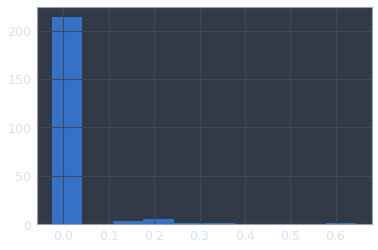

In [166]:
print(mtcs.accuracy_score(test_y, dfs.predict(test_X)))
plt.hist(dfs.get_features_weights());

In [171]:
train_X_dfs = dfs.transform(train_X, N=10)
test_X_dfs = dfs.transform(test_X, N=10)

fdf = DFS(num_epochs=500, verbose=True, dropout_rate=0.5, lambda1=0., alpha1=0.)

fdf.fit(train_X_dfs, train_y.y, test_data=(test_X_dfs, test_y))

==> Epoch: 0. Train loss: 18.39456409878201.Train accuracy: 0.7273755656108597. Test accuracy: 0.7330316742081447.
==> Epoch: 1. Train loss: 15.331250967802825.Train accuracy: 0.8167420814479638. Test accuracy: 0.832579185520362.
==> Epoch: 2. Train loss: 13.275470945570204.Train accuracy: 0.8484162895927602. Test accuracy: 0.8687782805429864.
==> Epoch: 3. Train loss: 12.253489847536441.Train accuracy: 0.8699095022624435. Test accuracy: 0.8959276018099548.
==> Epoch: 4. Train loss: 11.63012460426048.Train accuracy: 0.8755656108597285. Test accuracy: 0.9049773755656109.
==> Epoch: 5. Train loss: 11.020048088497585.Train accuracy: 0.8800904977375565. Test accuracy: 0.9049773755656109.
==> Epoch: 6. Train loss: 11.709815590469926.Train accuracy: 0.8755656108597285. Test accuracy: 0.8959276018099548.
==> Epoch: 7. Train loss: 11.459298336947406.Train accuracy: 0.8789592760180995. Test accuracy: 0.9049773755656109.
==> Epoch: 8. Train loss: 10.945051705395734.Train accuracy: 0.880090497737

==> Epoch: 72. Train loss: 8.749395970945004.Train accuracy: 0.8970588235294118. Test accuracy: 0.9140271493212669.
==> Epoch: 73. Train loss: 9.271473955225062.Train accuracy: 0.8970588235294118. Test accuracy: 0.9140271493212669.
==> Epoch: 74. Train loss: 9.161830213334826.Train accuracy: 0.8993212669683258. Test accuracy: 0.9140271493212669.
==> Epoch: 75. Train loss: 8.777003173474911.Train accuracy: 0.8993212669683258. Test accuracy: 0.9140271493212669.
==> Epoch: 76. Train loss: 8.745085257071036.Train accuracy: 0.8959276018099548. Test accuracy: 0.9140271493212669.
==> Epoch: 77. Train loss: 8.654491230293557.Train accuracy: 0.9015837104072398. Test accuracy: 0.9140271493212669.
==> Epoch: 78. Train loss: 8.947173047948766.Train accuracy: 0.8970588235294118. Test accuracy: 0.9140271493212669.
==> Epoch: 79. Train loss: 9.078781869676378.Train accuracy: 0.8993212669683258. Test accuracy: 0.9140271493212669.
==> Epoch: 80. Train loss: 8.643381577950937.Train accuracy: 0.897058823

==> Epoch: 144. Train loss: 7.831716272566053.Train accuracy: 0.918552036199095. Test accuracy: 0.918552036199095.
==> Epoch: 145. Train loss: 7.7638558811611595.Train accuracy: 0.9140271493212669. Test accuracy: 0.9004524886877828.
==> Epoch: 146. Train loss: 7.783398893144396.Train accuracy: 0.917420814479638. Test accuracy: 0.918552036199095.
==> Epoch: 147. Train loss: 7.863646277674922.Train accuracy: 0.915158371040724. Test accuracy: 0.9140271493212669.
==> Epoch: 148. Train loss: 7.309012836880154.Train accuracy: 0.916289592760181. Test accuracy: 0.9095022624434389.
==> Epoch: 149. Train loss: 7.641915294859144.Train accuracy: 0.916289592760181. Test accuracy: 0.918552036199095.
==> Epoch: 150. Train loss: 7.477460817054466.Train accuracy: 0.915158371040724. Test accuracy: 0.9140271493212669.
==> Epoch: 151. Train loss: 7.880555444293552.Train accuracy: 0.916289592760181. Test accuracy: 0.9140271493212669.
==> Epoch: 152. Train loss: 7.641387180045799.Train accuracy: 0.917420814

==> Epoch: 216. Train loss: 6.838218013445537.Train accuracy: 0.9332579185520362. Test accuracy: 0.9230769230769231.
==> Epoch: 217. Train loss: 7.044879772044994.Train accuracy: 0.9264705882352942. Test accuracy: 0.9140271493212669.
==> Epoch: 218. Train loss: 7.324964196593673.Train accuracy: 0.9298642533936652. Test accuracy: 0.918552036199095.
==> Epoch: 219. Train loss: 7.14614615616975.Train accuracy: 0.9253393665158371. Test accuracy: 0.9140271493212669.
==> Epoch: 220. Train loss: 6.755206832179317.Train accuracy: 0.9264705882352942. Test accuracy: 0.9140271493212669.
==> Epoch: 221. Train loss: 6.401606431713811.Train accuracy: 0.9276018099547512. Test accuracy: 0.9049773755656109.
==> Epoch: 222. Train loss: 6.354832852328265.Train accuracy: 0.9276018099547512. Test accuracy: 0.9140271493212669.
==> Epoch: 223. Train loss: 6.73168224758572.Train accuracy: 0.9332579185520362. Test accuracy: 0.918552036199095.
==> Epoch: 224. Train loss: 6.815730977941443.Train accuracy: 0.9276

==> Epoch: 288. Train loss: 6.58192354661447.Train accuracy: 0.9389140271493213. Test accuracy: 0.9095022624434389.
==> Epoch: 289. Train loss: 6.580384510534781.Train accuracy: 0.9377828054298643. Test accuracy: 0.9095022624434389.
==> Epoch: 290. Train loss: 6.256708842736703.Train accuracy: 0.9423076923076923. Test accuracy: 0.918552036199095.
==> Epoch: 291. Train loss: 6.515086483072351.Train accuracy: 0.9411764705882353. Test accuracy: 0.9230769230769231.
==> Epoch: 292. Train loss: 6.094768162126894.Train accuracy: 0.9411764705882353. Test accuracy: 0.9140271493212669.
==> Epoch: 293. Train loss: 6.701187751911305.Train accuracy: 0.9411764705882353. Test accuracy: 0.918552036199095.
==> Epoch: 294. Train loss: 6.16094085905287.Train accuracy: 0.9389140271493213. Test accuracy: 0.918552036199095.
==> Epoch: 295. Train loss: 6.118492223598339.Train accuracy: 0.9400452488687783. Test accuracy: 0.918552036199095.
==> Epoch: 296. Train loss: 6.226013324878834.Train accuracy: 0.937782

==> Epoch: 360. Train loss: 5.966482833579734.Train accuracy: 0.9457013574660633. Test accuracy: 0.918552036199095.
==> Epoch: 361. Train loss: 6.021650265764307.Train accuracy: 0.9434389140271493. Test accuracy: 0.9140271493212669.
==> Epoch: 362. Train loss: 5.885782232990971.Train accuracy: 0.9445701357466063. Test accuracy: 0.9095022624434389.
==> Epoch: 363. Train loss: 5.560402516965513.Train accuracy: 0.9445701357466063. Test accuracy: 0.9140271493212669.
==> Epoch: 364. Train loss: 5.895897335476345.Train accuracy: 0.9400452488687783. Test accuracy: 0.918552036199095.
==> Epoch: 365. Train loss: 5.793952774118494.Train accuracy: 0.9400452488687783. Test accuracy: 0.918552036199095.
==> Epoch: 366. Train loss: 5.758964971259788.Train accuracy: 0.9434389140271493. Test accuracy: 0.918552036199095.
==> Epoch: 367. Train loss: 5.750263373057048.Train accuracy: 0.9400452488687783. Test accuracy: 0.9230769230769231.
==> Epoch: 368. Train loss: 5.82279904683431.Train accuracy: 0.94570

==> Epoch: 432. Train loss: 6.046310998775341.Train accuracy: 0.9468325791855203. Test accuracy: 0.9230769230769231.
==> Epoch: 433. Train loss: 5.308125487080327.Train accuracy: 0.9502262443438914. Test accuracy: 0.9140271493212669.
==> Epoch: 434. Train loss: 5.499607147993864.Train accuracy: 0.9502262443438914. Test accuracy: 0.9140271493212669.
==> Epoch: 435. Train loss: 5.768909101132993.Train accuracy: 0.9490950226244343. Test accuracy: 0.9095022624434389.
==> Epoch: 436. Train loss: 6.027627507845561.Train accuracy: 0.9457013574660633. Test accuracy: 0.9140271493212669.
==> Epoch: 437. Train loss: 5.2881281110975475.Train accuracy: 0.9423076923076923. Test accuracy: 0.9140271493212669.
==> Epoch: 438. Train loss: 5.51219493371469.Train accuracy: 0.9445701357466063. Test accuracy: 0.9140271493212669.
==> Epoch: 439. Train loss: 5.179479775605379.Train accuracy: 0.9468325791855203. Test accuracy: 0.9140271493212669.
==> Epoch: 440. Train loss: 5.779037850874442.Train accuracy: 0.

DFS(N=None, alpha1=0.0, alpha2=0.0, batch_size=32, dropout_rate=0.5,
  lambda1=0.0, lambda2=1.0, layers_sizes=[10, 128, 64, 2], num_epochs=500,
  verbose=True)

## Lasso

In [172]:
class LassoFS(BaseEstimator):
    def __init__(self, N=None, C=1.):
        self.N = N
        self.est = lm.LogisticRegression(penalty='l1', C=C)
        self.C = C
    
    def fit(self, X, y):
        self.est.fit(X, y)
        self.features = X.columns
        
        return self
    
    
    def transform(self, X, N=None):
        if N:
            features = list(self.select_most_important_ftrs(N))
        else:
            features = list(self.select_most_important_ftrs(self.N))
        
        return X[features]

    
    def predict(self, X):
        return self.est.predict(X)
    
    
    @property
    def coef_(self):
        return self.est.coef_


    def select_most_important_ftrs(self, N):
        feature_weight = sorted(zip(self.est.coef_[0], self.features),
                                key=lambda x: abs(x[0]))

        return list(map(lambda x: x[1], feature_weight[-N:]))
    
    def select_most_important_ftrs_thresh(self, thresh=0.15):
        weights = self.est.coef_[0]
        feature_weight = filter(lambda x: x[0] >= thresh,
                                zip(weights, self.features))
        
        return map(lambda x: x[1], feature_weight)

0.886877828054


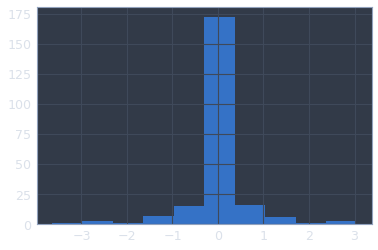

In [173]:
lassofs = LassoFS(C=1);
lassofs.fit(train_X, train_y.y);
print(mtcs.accuracy_score(test_y, lassofs.predict(test_X)))
plt.hist(lassofs.coef_[0]);

In [174]:
train_X_lasso = lassofs.transform(train_X, N=10)
test_X_lasso = lassofs.transform(test_X, N=10)

fdf = DFS(num_epochs=500, verbose=True, dropout_rate=0.5, lambda1=0., alpha1=0.)

fdf.fit(train_X_lasso, train_y.y, test_data=(test_X_lasso, test_y))

==> Epoch: 0. Train loss: 18.312629770349574.Train accuracy: 0.7262443438914027. Test accuracy: 0.7285067873303167.
==> Epoch: 1. Train loss: 15.185972460994014.Train accuracy: 0.8382352941176471. Test accuracy: 0.8733031674208145.
==> Epoch: 2. Train loss: 12.545572687078405.Train accuracy: 0.8450226244343891. Test accuracy: 0.8823529411764706.
==> Epoch: 3. Train loss: 12.54624926602399.Train accuracy: 0.8563348416289592. Test accuracy: 0.9004524886877828.
==> Epoch: 4. Train loss: 11.895811275199607.Train accuracy: 0.8472850678733032. Test accuracy: 0.9049773755656109.
==> Epoch: 5. Train loss: 12.149624400668674.Train accuracy: 0.8472850678733032. Test accuracy: 0.9049773755656109.
==> Epoch: 6. Train loss: 11.75709961078785.Train accuracy: 0.8529411764705882. Test accuracy: 0.9049773755656109.
==> Epoch: 7. Train loss: 11.692636030691641.Train accuracy: 0.8540723981900452. Test accuracy: 0.9095022624434389.
==> Epoch: 8. Train loss: 11.229083520394784.Train accuracy: 0.85633484162

==> Epoch: 72. Train loss: 9.104272383230704.Train accuracy: 0.8857466063348416. Test accuracy: 0.918552036199095.
==> Epoch: 73. Train loss: 9.215653852180198.Train accuracy: 0.8857466063348416. Test accuracy: 0.9004524886877828.
==> Epoch: 74. Train loss: 9.285649140675863.Train accuracy: 0.8936651583710408. Test accuracy: 0.9049773755656109.
==> Epoch: 75. Train loss: 9.26683470054909.Train accuracy: 0.8959276018099548. Test accuracy: 0.8959276018099548.
==> Epoch: 76. Train loss: 8.702714072333443.Train accuracy: 0.8857466063348416. Test accuracy: 0.9140271493212669.
==> Epoch: 77. Train loss: 9.443929424992314.Train accuracy: 0.8936651583710408. Test accuracy: 0.8959276018099548.
==> Epoch: 78. Train loss: 9.161281047043976.Train accuracy: 0.8914027149321267. Test accuracy: 0.9140271493212669.
==> Epoch: 79. Train loss: 9.36915816201104.Train accuracy: 0.8902714932126696. Test accuracy: 0.8914027149321267.
==> Epoch: 80. Train loss: 9.060346002931949.Train accuracy: 0.888009049773

==> Epoch: 144. Train loss: 8.78042525715298.Train accuracy: 0.9004524886877828. Test accuracy: 0.9004524886877828.
==> Epoch: 145. Train loss: 8.428861017580386.Train accuracy: 0.9027149321266968. Test accuracy: 0.9095022624434389.
==> Epoch: 146. Train loss: 8.909655809402466.Train accuracy: 0.8981900452488688. Test accuracy: 0.9004524886877828.
==> Epoch: 147. Train loss: 8.506610799718786.Train accuracy: 0.9061085972850679. Test accuracy: 0.8959276018099548.
==> Epoch: 148. Train loss: 8.554041544596354.Train accuracy: 0.8981900452488688. Test accuracy: 0.9004524886877828.
==> Epoch: 149. Train loss: 8.540800712726734.Train accuracy: 0.8981900452488688. Test accuracy: 0.9049773755656109.
==> Epoch: 150. Train loss: 8.865196272178933.Train accuracy: 0.9027149321266968. Test accuracy: 0.9095022624434389.
==> Epoch: 151. Train loss: 8.625647951055456.Train accuracy: 0.8959276018099548. Test accuracy: 0.9004524886877828.
==> Epoch: 152. Train loss: 9.28069512049357.Train accuracy: 0.88

==> Epoch: 216. Train loss: 8.476712456455937.Train accuracy: 0.9049773755656109. Test accuracy: 0.8914027149321267.
==> Epoch: 217. Train loss: 8.335472760377106.Train accuracy: 0.9117647058823529. Test accuracy: 0.9095022624434389.
==> Epoch: 218. Train loss: 8.52096274163988.Train accuracy: 0.9049773755656109. Test accuracy: 0.8959276018099548.
==> Epoch: 219. Train loss: 8.169001579284668.Train accuracy: 0.9083710407239819. Test accuracy: 0.8959276018099548.
==> Epoch: 220. Train loss: 8.006993523350468.Train accuracy: 0.9095022624434389. Test accuracy: 0.8959276018099548.
==> Epoch: 221. Train loss: 7.99824873606364.Train accuracy: 0.9061085972850679. Test accuracy: 0.9004524886877828.
==> Epoch: 222. Train loss: 8.098581631978353.Train accuracy: 0.9038461538461539. Test accuracy: 0.8914027149321267.
==> Epoch: 223. Train loss: 7.8813466584240945.Train accuracy: 0.9049773755656109. Test accuracy: 0.8959276018099548.
==> Epoch: 224. Train loss: 8.331896631805986.Train accuracy: 0.9

==> Epoch: 288. Train loss: 7.952561943619339.Train accuracy: 0.9128959276018099. Test accuracy: 0.8959276018099548.
==> Epoch: 289. Train loss: 7.977580220611007.Train accuracy: 0.9095022624434389. Test accuracy: 0.9004524886877828.
==> Epoch: 290. Train loss: 7.714987684179236.Train accuracy: 0.9128959276018099. Test accuracy: 0.8868778280542986.
==> Epoch: 291. Train loss: 7.8206715318891735.Train accuracy: 0.9106334841628959. Test accuracy: 0.8959276018099548.
==> Epoch: 292. Train loss: 7.7673275382430464.Train accuracy: 0.9128959276018099. Test accuracy: 0.8959276018099548.
==> Epoch: 293. Train loss: 7.9600338229426635.Train accuracy: 0.9128959276018099. Test accuracy: 0.9004524886877828.
==> Epoch: 294. Train loss: 7.696505113884255.Train accuracy: 0.9117647058823529. Test accuracy: 0.9004524886877828.
==> Epoch: 295. Train loss: 7.801566353550664.Train accuracy: 0.9128959276018099. Test accuracy: 0.8959276018099548.
==> Epoch: 296. Train loss: 8.495604002917254.Train accuracy:

==> Epoch: 360. Train loss: 7.6393320913668035.Train accuracy: 0.9117647058823529. Test accuracy: 0.9140271493212669.
==> Epoch: 361. Train loss: 8.109697015197188.Train accuracy: 0.9140271493212669. Test accuracy: 0.9049773755656109.
==> Epoch: 362. Train loss: 7.727642677448414.Train accuracy: 0.9140271493212669. Test accuracy: 0.8959276018099548.
==> Epoch: 363. Train loss: 7.2749607739625155.Train accuracy: 0.917420814479638. Test accuracy: 0.8914027149321267.
==> Epoch: 364. Train loss: 7.302373426931876.Train accuracy: 0.9128959276018099. Test accuracy: 0.8959276018099548.
==> Epoch: 365. Train loss: 7.941387167683354.Train accuracy: 0.915158371040724. Test accuracy: 0.8914027149321267.
==> Epoch: 366. Train loss: 7.107550126534921.Train accuracy: 0.915158371040724. Test accuracy: 0.9049773755656109.
==> Epoch: 367. Train loss: 7.834241496192084.Train accuracy: 0.917420814479638. Test accuracy: 0.9095022624434389.
==> Epoch: 368. Train loss: 7.580321903581972.Train accuracy: 0.91

==> Epoch: 432. Train loss: 7.320306045037729.Train accuracy: 0.919683257918552. Test accuracy: 0.9049773755656109.
==> Epoch: 433. Train loss: 7.527413094485247.Train accuracy: 0.916289592760181. Test accuracy: 0.9095022624434389.
==> Epoch: 434. Train loss: 7.280081590016683.Train accuracy: 0.9230769230769231. Test accuracy: 0.9004524886877828.
==> Epoch: 435. Train loss: 7.38938848177592.Train accuracy: 0.916289592760181. Test accuracy: 0.9140271493212669.
==> Epoch: 436. Train loss: 7.635342509658249.Train accuracy: 0.916289592760181. Test accuracy: 0.9004524886877828.
==> Epoch: 437. Train loss: 7.173439374676457.Train accuracy: 0.916289592760181. Test accuracy: 0.9004524886877828.
==> Epoch: 438. Train loss: 7.68285663039596.Train accuracy: 0.920814479638009. Test accuracy: 0.9095022624434389.
==> Epoch: 439. Train loss: 7.084793161462854.Train accuracy: 0.918552036199095. Test accuracy: 0.918552036199095.
==> Epoch: 440. Train loss: 7.4403242888274015.Train accuracy: 0.919683257

DFS(N=None, alpha1=0.0, alpha2=0.0, batch_size=32, dropout_rate=0.5,
  lambda1=0.0, lambda2=1.0, layers_sizes=[10, 128, 64, 2], num_epochs=500,
  verbose=True)

## Random forest

In [33]:
class RandomForestFS(BaseEstimator):
    def __init__(self, N=None, max_depth=None):
        self.N = N
        self.max_depth = max_depth
        self.est = ens.RandomForestClassifier(max_features=None)

        
    def fit(self, X, y):
        self.est.fit(X, y)
        self.features = X.columns
        
        return self
    
    
    def transform(self, X, N=None):
        if N:
            features = self.select_most_important_ftrs(N)
        else:
            features = self.select_most_important_ftrs(self.N)
            
        return X[features]

    
    def predict(self, X):
        return self.est.predict(X)
    
    
    @property
    def feature_importances_(self):
        return self.est.feature_importances_
    
    
    def select_most_important_ftrs(self, N):
        feature_weight = sorted( zip(self.est.feature_importances_,
                                     self.features),
                                 key=lambda x: x[0])
        return list(map(lambda x: x[1], feature_weight[-N:]))

    
    def select_most_important_ftrs_thresh(self, thresh=0.01):
        weights = self.est.feature_importances_
        feature_weight = filter(lambda x: x[0] >= thresh,
                                zip(weights, self.features))
        
        return map(lambda x: x[1], feature_weight)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


0.900452488688


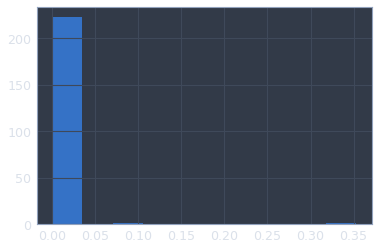

In [121]:
rf = RandomForestFS();
rf.fit(train_X, train_y);
print(mtcs.accuracy_score(test_y, rf.predict(test_X)))
plt.hist(rf.feature_importances_);

# Classification models

## Random Forest

In [20]:
est = ens.RandomForestClassifier()

train_X_dfs = dfs.transform(train_X, 500)
test_X_dfs = dfs.transform(test_X, 500)

est.fit(train_X_dfs, train_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
mtcs.accuracy_score(test_y, est.predict(test_X_dfs))

0.85520361990950222

In [107]:
ztest(acc_p, acc_dfs)

(-1.8637867739884362, 0.062351653820433672)

## Gradient Boosting

In [ ]:
def select_most_important_ftrs(est, features, N):
    feature_weight = sorted(zip(est.coef_[0], features),
                            key=lambda x: abs(x[0]))
    
    return list(map(lambda x: x[1], feature_weight[-N:]))

In [128]:
est = XGBClassifier(n_estimators=1000, n_jobs=40, silent=False)

est.fit(train_X_dfs, train_y, verbose=True)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=40, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=1)

In [124]:
mtcs.accuracy_score(test_y, est.predict(test_X))

0.8876811594202898

In [125]:
est.feature_importances_

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

# Hyperparameters optimization

In [218]:
NUM_FEATURES = [5, 10, 15, 20, 25]

In [210]:
def evaluate(main_model, feature_selector, param_grid, 
             X, y, scoring='accuracy', caching=False):

    if main_model is not None:
        pipeline_list = [('select_ftrs', feature_selector),
                         ('main', main_model)]
    else:
        pipeline_list = [('select_ftrs', feature_selector)]

    if caching:
        pipeline = Pipeline(pipeline_list, memory=mkdtemp())
    else:
        pipeline = Pipeline(pipeline_list)
    
    grid = ms.GridSearchCV(pipeline, cv=ms.StratifiedKFold(n_splits=5,
                                                           shuffle=True),
                           n_jobs=1, param_grid=param_grid,
                           verbose=100, scoring=scoring)
    print('=====', X.shape)
    grid.fit(X, y)
    
    return grid

In [212]:
all_scores = dict()

In [642]:
##### DFS + RandomForest #####
param_grid = [
    {
     'select_ftrs__N': NUM_FEATURES,
     'select_ftrs__lambda1': np.arange(0, 0.05, 0.025)
#      'main__n_estimators': [10, 25, 50]
    }
]

all_scores['DFS + RF'] = evaluate(ens.RandomForestClassifier(),
                                  DFS(), param_grid, data_X, data_y.y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] select_ftrs__N=5, select_ftrs__lambda1=0.0 ......................
[CV]  select_ftrs__N=5, select_ftrs__lambda1=0.0, score=0.7642276422764228, total=   2.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[CV] select_ftrs__N=5, select_ftrs__lambda1=0.0 ......................
[CV]  select_ftrs__N=5, select_ftrs__lambda1=0.0, score=0.8125, total=   2.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s
[CV] select_ftrs__N=5, select_ftrs__lambda1=0.0 ......................


KeyboardInterrupt: 

In [265]:
##### DFS + Gradient Boosting #####
param_grid = [
    {
     'select_ftrs__N': NUM_FEATURES,
     'select_ftrs__lambda1': np.arange(0, 0.05, 0.025),
     'main__random_state': [10]
    }
]

all_scores['DFS + GB'] = evaluate(XGBClassifier(),
                                  DFS(), param_grid, data_X, data_y.y)

Fitting 3 folds for each of 22 candidates, totalling 66 fits
[CV] main__random_state=10, select_ftrs__N=10, select_ftrs__lambda1=0.0 
[CV]  main__random_state=10, select_ftrs__N=10, select_ftrs__lambda1=0.0, score=0.8672086720867209, total=   2.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__N=10, select_ftrs__lambda1=0.0 
[CV]  main__random_state=10, select_ftrs__N=10, select_ftrs__lambda1=0.0, score=0.8505434782608695, total=   2.5s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__N=10, select_ftrs__lambda1=0.0 
[CV]  main__random_state=10, select_ftrs__N=10, select_ftrs__lambda1=0.0, score=0.8070652173913043, total=   2.5s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.7s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__N=10, select_ftrs__lambda1=0.025 
[CV]  main__random_state=10, select_ftrs__N=10, select_ftrs__la

[CV]  main__random_state=10, select_ftrs__N=125, select_ftrs__lambda1=0.0, score=0.8586956521739131, total=   4.5s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  1.5min remaining:    0.0s
[CV] main__random_state=10, select_ftrs__N=125, select_ftrs__lambda1=0.0 
[CV]  main__random_state=10, select_ftrs__N=125, select_ftrs__lambda1=0.0, score=0.8804347826086957, total=   2.9s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  1.6min remaining:    0.0s
[CV] main__random_state=10, select_ftrs__N=125, select_ftrs__lambda1=0.025 
[CV]  main__random_state=10, select_ftrs__N=125, select_ftrs__lambda1=0.025, score=0.9051490514905149, total=   2.9s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  1.6min remaining:    0.0s
[CV] main__random_state=10, select_ftrs__N=125, select_ftrs__lambda1=0.025 
[CV]  main__random_state=10, select_ftrs__N=125, select_ftrs__lambda1=0.025, score=0.8641304347826086, total=   3.1s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.7min remaining

[CV]  main__random_state=10, select_ftrs__N=1524, select_ftrs__lambda1=0.0, score=0.8722826086956522, total=   7.3s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:  3.4min remaining:    0.0s
[CV] main__random_state=10, select_ftrs__N=1524, select_ftrs__lambda1=0.025 
[CV]  main__random_state=10, select_ftrs__N=1524, select_ftrs__lambda1=0.025, score=0.9024390243902439, total=   8.1s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:  3.6min remaining:    0.0s
[CV] main__random_state=10, select_ftrs__N=1524, select_ftrs__lambda1=0.025 
[CV]  main__random_state=10, select_ftrs__N=1524, select_ftrs__lambda1=0.025, score=0.8641304347826086, total=   7.8s
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  3.7min remaining:    0.0s
[CV] main__random_state=10, select_ftrs__N=1524, select_ftrs__lambda1=0.025 
[CV]  main__random_state=10, select_ftrs__N=1524, select_ftrs__lambda1=0.025, score=0.8668478260869565, total=  10.0s
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:  3.9mi

In [266]:
##### LassoFS + RandomForest #####
param_grid = [
    {
     'select_ftrs__N':  NUM_FEATURES,
     'select_ftrs__C': np.arange(0.25, 1., 0.25) 
    }
]

all_scores['Lasso + RF'] =  evaluate(ens.RandomForestClassifier(),
                                     LassoFS(), param_grid, data_X, data_y.y)

Fitting 3 folds for each of 33 candidates, totalling 99 fits
[CV] select_ftrs__C=0.25, select_ftrs__N=10 ..........................
[CV]  select_ftrs__C=0.25, select_ftrs__N=10, score=0.8590785907859079, total=   0.5s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[CV] select_ftrs__C=0.25, select_ftrs__N=10 ..........................
[CV]  select_ftrs__C=0.25, select_ftrs__N=10, score=0.8695652173913043, total=   0.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[CV] select_ftrs__C=0.25, select_ftrs__N=10 ..........................
[CV]  select_ftrs__C=0.25, select_ftrs__N=10, score=0.8070652173913043, total=   0.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[CV] select_ftrs__C=0.25, select_ftrs__N=25 ..........................
[CV]  select_ftrs__C=0.25, select_ftrs__N=25, score=0.8753387533875339, total=   0.3s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:

[CV]  select_ftrs__C=0.5, select_ftrs__N=10, score=0.875, total=   0.3s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   12.1s remaining:    0.0s
[CV] select_ftrs__C=0.5, select_ftrs__N=10 ...........................
[CV]  select_ftrs__C=0.5, select_ftrs__N=10, score=0.75, total=   0.3s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   12.3s remaining:    0.0s
[CV] select_ftrs__C=0.5, select_ftrs__N=25 ...........................
[CV]  select_ftrs__C=0.5, select_ftrs__N=25, score=0.8509485094850948, total=   0.3s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:   12.7s remaining:    0.0s
[CV] select_ftrs__C=0.5, select_ftrs__N=25 ...........................
[CV]  select_ftrs__C=0.5, select_ftrs__N=25, score=0.8586956521739131, total=   0.3s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   13.0s remaining:    0.0s
[CV] select_ftrs__C=0.5, select_ftrs__N=25 ...........................
[CV]  select_ftrs__C=0.5, select_ftrs__N=25, score=0.8260869565217391, total=   0.3

[CV]  select_ftrs__C=0.75, select_ftrs__N=25, score=0.8753387533875339, total=   0.3s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   24.0s remaining:    0.0s
[CV] select_ftrs__C=0.75, select_ftrs__N=25 ..........................
[CV]  select_ftrs__C=0.75, select_ftrs__N=25, score=0.8505434782608695, total=   0.3s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:   24.3s remaining:    0.0s
[CV] select_ftrs__C=0.75, select_ftrs__N=25 ..........................
[CV]  select_ftrs__C=0.75, select_ftrs__N=25, score=0.8125, total=   0.3s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   24.6s remaining:    0.0s
[CV] select_ftrs__C=0.75, select_ftrs__N=50 ..........................
[CV]  select_ftrs__C=0.75, select_ftrs__N=50, score=0.8455284552845529, total=   0.3s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   24.9s remaining:    0.0s
[CV] select_ftrs__C=0.75, select_ftrs__N=50 ..........................
[CV]  select_ftrs__C=0.75, select_ftrs__N=50, score=0.8505434782

In [267]:
##### LassoFS + GradientBoosting #####
param_grid = [
    {
     'select_ftrs__N':  NUM_FEATURES,
     'select_ftrs__C': np.arange(0.25, 1., 0.25),
     'main__random_state': [10]
    }
]

all_scores['Lasso + GB'] = evaluate(XGBClassifier(),
                                    LassoFS(), param_grid, data_X, data_y.y)

Fitting 3 folds for each of 33 candidates, totalling 99 fits
[CV] main__random_state=10, select_ftrs__C=0.25, select_ftrs__N=10 ...
[CV]  main__random_state=10, select_ftrs__C=0.25, select_ftrs__N=10, score=0.8319783197831978, total=   0.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.25, select_ftrs__N=10 ...
[CV]  main__random_state=10, select_ftrs__C=0.25, select_ftrs__N=10, score=0.8858695652173914, total=   0.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.25, select_ftrs__N=10 ...
[CV]  main__random_state=10, select_ftrs__C=0.25, select_ftrs__N=10, score=0.8478260869565217, total=   0.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.25, select_ftrs__N=25 ...
[CV]  main__random_state=10, select_ftrs__C=0.25, select_ftrs__N=25, score=0.84281842818

[CV]  main__random_state=10, select_ftrs__C=0.25, select_ftrs__N=1524, score=0.9021739130434783, total=   5.6s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:   30.3s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.25, select_ftrs__N=1524 .
[CV]  main__random_state=10, select_ftrs__C=0.25, select_ftrs__N=1524, score=0.8695652173913043, total=   5.6s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   36.0s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.5, select_ftrs__N=10 ....
[CV]  main__random_state=10, select_ftrs__C=0.5, select_ftrs__N=10, score=0.8401084010840109, total=   0.4s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   36.4s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.5, select_ftrs__N=10 ....
[CV]  main__random_state=10, select_ftrs__C=0.5, select_ftrs__N=10, score=0.8858695652173914, total=   0.4s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   36.8s remaining:    0.0s
[CV] main__random_state=10, s

[CV]  main__random_state=10, select_ftrs__C=0.5, select_ftrs__N=1524, score=0.8590785907859079, total=   5.6s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:  1.0min remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.5, select_ftrs__N=1524 ..
[CV]  main__random_state=10, select_ftrs__C=0.5, select_ftrs__N=1524, score=0.9021739130434783, total=   5.2s
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  1.1min remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.5, select_ftrs__N=1524 ..
[CV]  main__random_state=10, select_ftrs__C=0.5, select_ftrs__N=1524, score=0.8695652173913043, total=   5.4s
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:  1.2min remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.75, select_ftrs__N=10 ...
[CV]  main__random_state=10, select_ftrs__C=0.75, select_ftrs__N=10, score=0.8401084010840109, total=   0.3s
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:  1.2min remaining:    0.0s
[CV] main__random_state=10, 

[CV]  main__random_state=10, select_ftrs__C=0.75, select_ftrs__N=225, score=0.8614130434782609, total=   0.8s
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  1.5min remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.75, select_ftrs__N=1524 .
[CV]  main__random_state=10, select_ftrs__C=0.75, select_ftrs__N=1524, score=0.8590785907859079, total=   5.5s
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:  1.6min remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.75, select_ftrs__N=1524 .
[CV]  main__random_state=10, select_ftrs__C=0.75, select_ftrs__N=1524, score=0.9021739130434783, total=   5.4s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:  1.7min remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.75, select_ftrs__N=1524 .
[CV]  main__random_state=10, select_ftrs__C=0.75, select_ftrs__N=1524, score=0.8695652173913043, total=   5.1s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Do

In [314]:
##### Pure DFS #####
param_grid = [
    {
        'select_ftrs__layers_sizes': [[32, 16, 2]],
        'select_ftrs__N': NUM_FEATURES,
        'select_ftrs__lambda1': [5e-2],
        'select_ftrs__num_epochs': [150],
        'select_ftrs__verbose': [True],
        'select_ftrs__test_data': [[test_X, test_y]],
        'select_ftrs__dropout_rate': [0.1]
    }
]

all_scores['DFS'] = evaluate(None, DFS(),
                             param_grid, data_X, data_y.y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] select_ftrs__N=1, select_ftrs__dropout_rate=0.1, select_ftrs__lambda1=0.05, select_ftrs__layers_sizes=[32, 16, 2], select_ftrs__num_epochs=150, select_ftrs__test_data=[      feature-0  feature-1  feature-2  feature-3  feature-4  feature-5  \
670   -0.478645  -1.561921  -0.696277  -1.296979  -1.318790  -0.385580   
174   -0.290262  -0.040104  -0.726574  -0.251104   0.185794  -0.248343   
137   -0.474567  -0.808953  -1.233911  -0.978462   0.955691  -0.384228   
153    0.147392   0.569413   0.099982   0.533354   0.325037   0.071959   
523   -0.450602  -0.921771  -1.369119  -1.009942   0.419665  -0.366032   
782   -0.209702   0.071686   1.122537   0.292190  -0.379046  -0.188343   
894   -0.398907  -0.478920  -0.909908  -0.664656   0.129416  -0.328596   
646   -0.163512  -1.210361  -1.191512  -1.582176   0.622506  -0.156864   
740   -0.107282  -0.338189  -0.099083  -0.403904  -0.033842  -0.108371   
628   -0.236061  -0.203786

==> Epoch: 0. Train loss: 100.59648497208305.Train accuracy: 0.6915760869565217. Test accuracy: 0.7104072398190046.
==> Epoch: 1. Train loss: 99.0601056969684.Train accuracy: 0.7282608695652174. Test accuracy: 0.7420814479638009.
==> Epoch: 2. Train loss: 96.26917266845703.Train accuracy: 0.7391304347826086. Test accuracy: 0.751131221719457.
==> Epoch: 3. Train loss: 96.36596845543903.Train accuracy: 0.7730978260869565. Test accuracy: 0.7647058823529411.
==> Epoch: 4. Train loss: 94.9281702456267.Train accuracy: 0.78125. Test accuracy: 0.7737556561085973.
==> Epoch: 5. Train loss: 92.84950256347656.Train accuracy: 0.7771739130434783. Test accuracy: 0.751131221719457.
==> Epoch: 6. Train loss: 91.57225633704144.Train accuracy: 0.7744565217391305. Test accuracy: 0.755656108597285.


KeyboardInterrupt: 

In [313]:
##### Pure Lasso #####
param_grid = [
    {
     'select_ftrs__N':  NUM_FEATURES,
     'select_ftrs__C': np.arange(0.25, 1., 0.25) 
    }
]

all_scores['Lasso'] = evaluate( None, LassoFS(),
                             param_grid, data_X, data_y.y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] select_ftrs__N=1, select_ftrs__dropout_rate=0.1, select_ftrs__lambda1=0.05, select_ftrs__layers_sizes=[32, 16, 2], select_ftrs__num_epochs=150, select_ftrs__test_data=[      feature-0  feature-1  feature-2  feature-3  feature-4  feature-5  \
670   -0.478645  -1.561921  -0.696277  -1.296979  -1.318790  -0.385580   
174   -0.290262  -0.040104  -0.726574  -0.251104   0.185794  -0.248343   
137   -0.474567  -0.808953  -1.233911  -0.978462   0.955691  -0.384228   
153    0.147392   0.569413   0.099982   0.533354   0.325037   0.071959   
523   -0.450602  -0.921771  -1.369119  -1.009942   0.419665  -0.366032   
782   -0.209702   0.071686   1.122537   0.292190  -0.379046  -0.188343   
894   -0.398907  -0.478920  -0.909908  -0.664656   0.129416  -0.328596   
646   -0.163512  -1.210361  -1.191512  -1.582176   0.622506  -0.156864   
740   -0.107282  -0.338189  -0.099083  -0.403904  -0.033842  -0.108371   
628   -0.236061  -0.203786

ValueError: Invalid parameter dropout_rate for estimator LassoFS(C=1.0, N=1). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
fdf = DFS(num_epochs=100, verbose=True, dropout_rate=0.5, lambda1=0., alpha1=0.)

In [219]:
##### DFS + MLP #####
param_grid = [
    {
        'select_ftrs__layers_sizes': [[64, 64, 32, 2]],
        'select_ftrs__N': NUM_FEATURES,
        'select_ftrs__lambda1': [0.07],
        'select_ftrs__num_epochs': [100],
        'select_ftrs__dropout_rate': [0.25],
        
        'main__num_epochs': [100],
        'main__dropout_rate': [0.5],
        'main__lambda1': [0.],
        'main__alpha1': [0.]
    }
]

all_scores['DFS + MLP'] = evaluate(DFS(), DFS(),
                                   param_grid, data_X, data_y.y)

===== (1105, 225)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=10, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=10, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.9004524886877828, total=  26.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.2s remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=10, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100

[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=20, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8687782805429864, total=  25.3s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  6.5min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=25, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=25, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8868778280542986, total=  26.1s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  7.0min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.

In [220]:
##### Lasso + MLP #####
param_grid = [
    {
        'select_ftrs__N': NUM_FEATURES,
        'select_ftrs__C': [1.],
        
        'main__num_epochs': [100],
        'main__dropout_rate': [0.5],
        'main__lambda1': [0.],
        'main__alpha1': [0.]
    }
]

all_scores['Lasso + MLP'] = evaluate(DFS(), LassoFS(),
                                   param_grid, data_X, data_y.y)

===== (1105, 225)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=1.0, select_ftrs__N=10 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=1.0, select_ftrs__N=10, score=0.8461538461538461, total=  12.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=1.0, select_ftrs__N=10 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=1.0, select_ftrs__N=10, score=0.8778280542986425, total=  11.9s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.0s remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=1.0, select_ftrs__N=10 
[CV]  main__alpha1=0.0, main__dropout_rate=0.

# Plotting

In [221]:
colors = {'DFS + RF': 'blue',
          'DFS + GB': 'green',
          'Lasso + RF': 'red',
          'Lasso + GB': 'pink',
          'DFS': 'brown',
          'Lasso': 'orange',
          'DFS + MLP': 'greenyellow',
          'Lasso + MLP': 'cyan'}

In [222]:
def get_test_scores(all_scores, experiment):
    param_id = dict()
    cur_results = all_scores[experiment].cv_results_

    for i, params in enumerate(cur_results['params']):
        key = params['select_ftrs__N']
        if key in param_id:
            param_id[key].append(i)
        else:
            param_id[key] = [i]

    max_test_score = {}
    all_test_scores = {}
    for ts in param_id.keys():
        all_test_scores[ts] = cur_results['mean_test_score'][param_id[ts]]
        max_test_score[ts] = max(all_test_scores[ts])
    
    return max_test_score, all_test_scores

def plot(all_scores):
    p = figure(plot_width=1000)
    for i, score_title in enumerate(all_scores):
        max_scores, _ = get_test_scores(all_scores, score_title)
        
        p.line(x = list(max_scores.keys()), 
               y = list(max_scores.values()),
               legend=score_title,
               line_color=colors[score_title])
        p.circle(x = list(max_scores.keys()), 
               y = list(max_scores.values()),
               legend=score_title,
               color=colors[score_title],
               alpha=1.)
        
    
    p.legend.location = 'bottom_right'
    p.legend.click_policy = 'hide'

    show(p)

In [223]:
plot(all_scores)

In [256]:
plot(all_scores)

In [285]:
plot(all_scores)

feature-321


KeyError: 'feature-321'

In [483]:
data['feature-806'].unique()

array([-1.])

In [46]:
0.402251 / 0.156062

2.5775076572131588